<a href="https://colab.research.google.com/github/beccalunch/adv-ml-playground/blob/main/inside-deep-learning/ch1_dl_intro_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanics of Learning
- Deep learning is a subdomain of machine learning, which is a subdomain of artificial intelligence
- AI is getting a computer to make any decision that "looks" smart, because intelligence is subjective
- (Supervised) ML makes decisions based on prior examples
- Deep learning is hundreds of small algorithms that act as building blocks
- Applying these blocks repeatedly is what makes up the "deep" part of "deep learning"
- Being a good practicioner of deep learning means understanding which building blocks are available and which ones work best for the problem you are trying to solve.

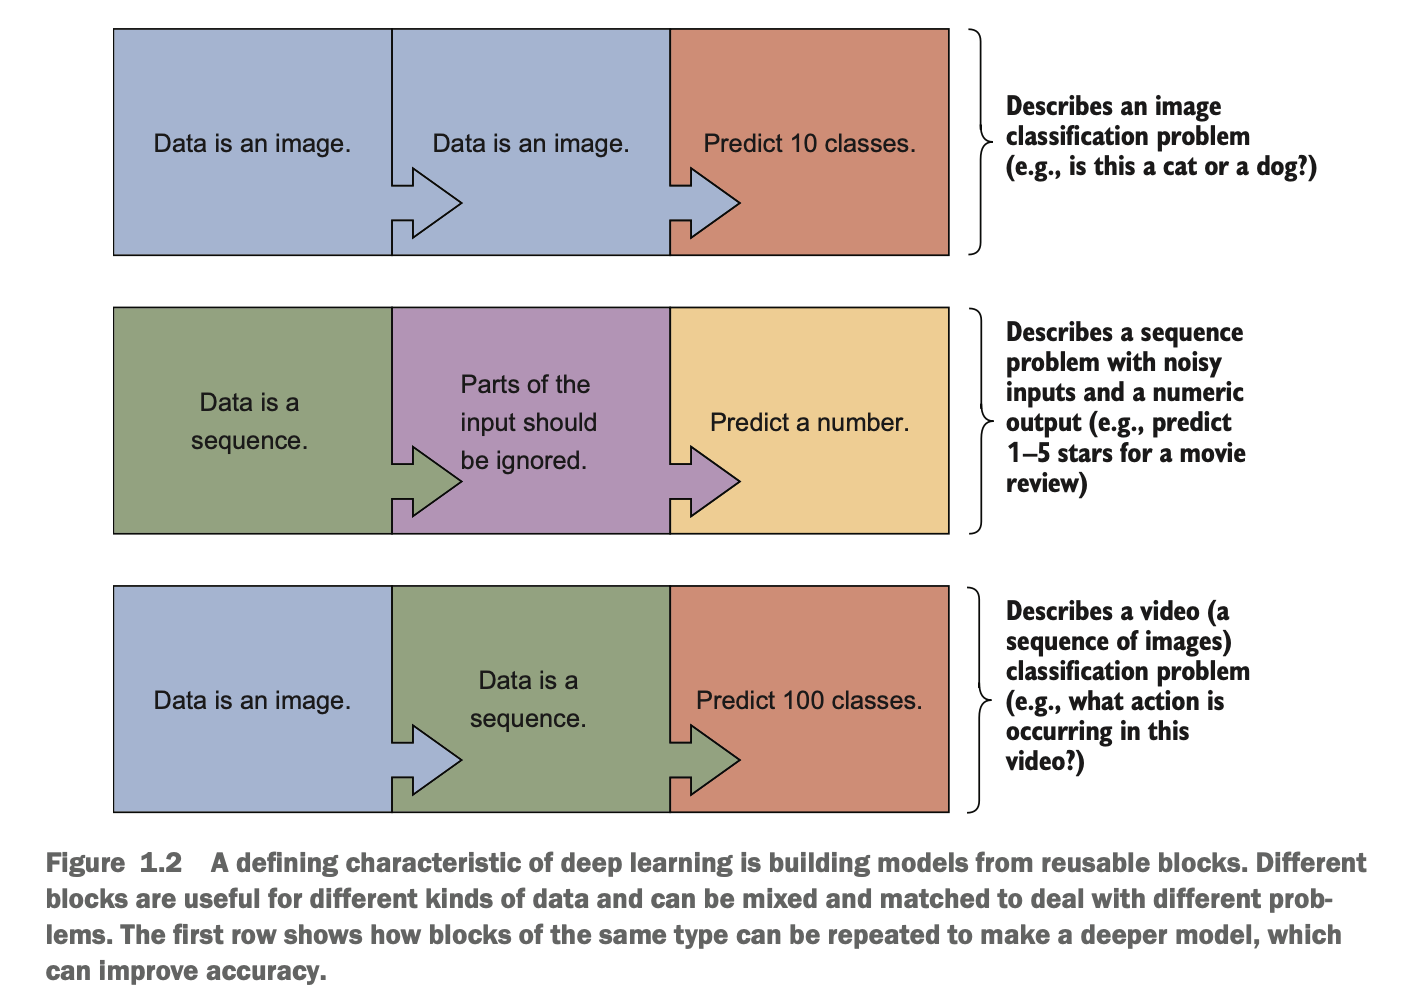

- "Learning" refers to the optimization or function minimization of the functions that make up the building blocks, and the parameters needed to optimize those functions are what is "learned"

# Tensors
- A tensor is a n-dimensional array for any value of n
- It is simply a n-dimensional array upon which PyTorch can perform parallel computation via GPUs, as well as the automatic ability to perform calculus on the object


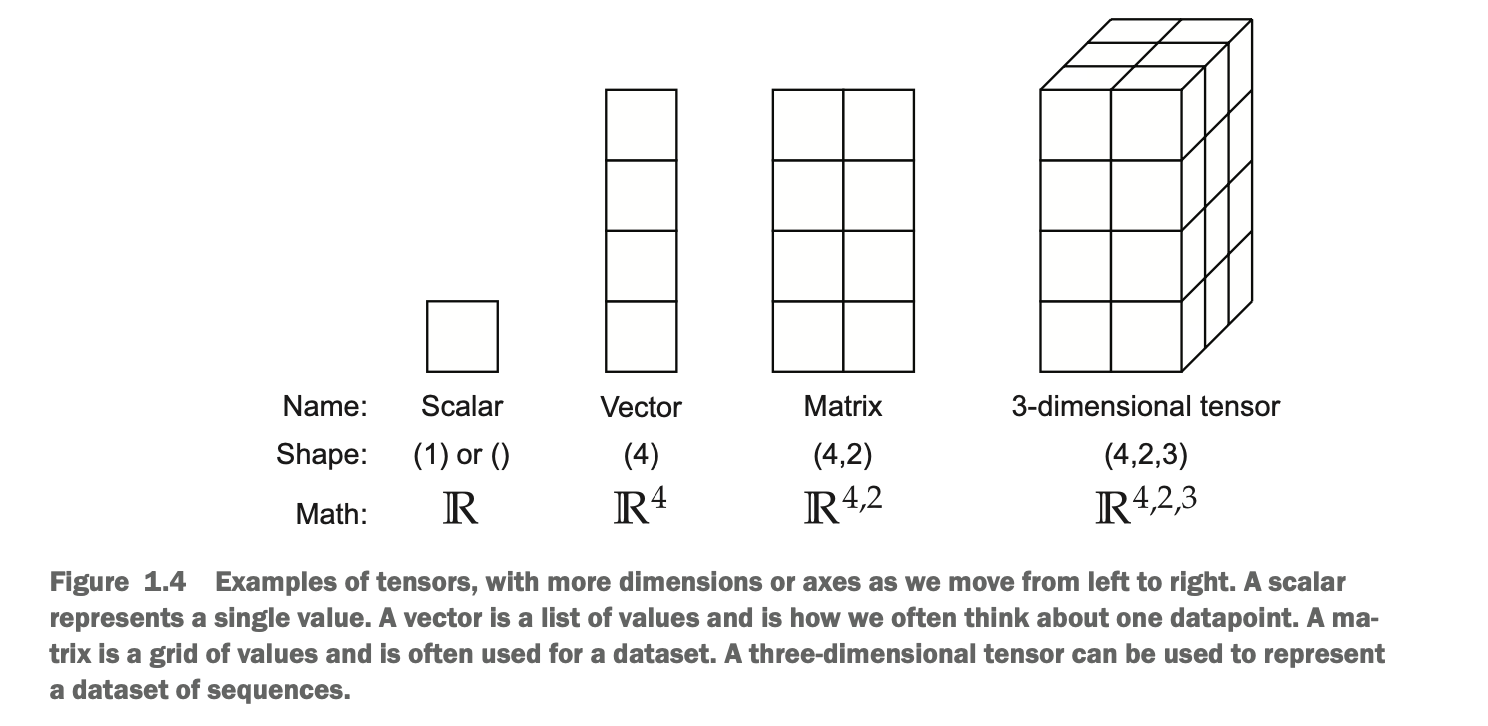

- Slices of tensors can be accessed via "slicing"
  - The ith row of matrix $X$, which would be notated **$x_i$**, could be accessed `x_i = X[i,:]`
- The retrieved slice is still a tensor object, because it is an n-dimensional array

## Tensor shape / size

In [1]:
import torch

torch_scalar = torch.tensor(3.14)
print(torch_scalar)
print(type(torch_scalar))

torch_vector = torch.tensor([1, 2, 3, 4])
print(torch_vector)
print(type(torch_vector))

torch_matrix = torch.tensor([[1, 2,],
                             [3, 4,],
                             [5, 6,],
                             [7, 8,]])
print(torch_matrix)
print(type(torch_matrix))

tensor(3.1400)
<class 'torch.Tensor'>
tensor([1, 2, 3, 4])
<class 'torch.Tensor'>
tensor([[1, 2],
        [3, 4],
        [5, 6],
        [7, 8]])
<class 'torch.Tensor'>


In [3]:
print(torch_scalar.shape)
print(torch_vector.shape)
print(torch_matrix.shape)

torch.Size([])
torch.Size([4])
torch.Size([4, 2])


## Numpy
- Numpy objects can be easily converted into Tensors

In [4]:
import numpy as np

x_np = np.random.random((4,4))
print(x_np)

x_pt = torch.tensor(x_np)
print(x_pt)

[[0.46985357 0.85492801 0.50508784 0.3933259 ]
 [0.65104477 0.4971379  0.92942155 0.52166745]
 [0.27764442 0.72210017 0.77414945 0.23016177]
 [0.28385077 0.63882101 0.81566303 0.50375606]]
tensor([[0.4699, 0.8549, 0.5051, 0.3933],
        [0.6510, 0.4971, 0.9294, 0.5217],
        [0.2776, 0.7221, 0.7741, 0.2302],
        [0.2839, 0.6388, 0.8157, 0.5038]], dtype=torch.float64)


- By default, Numpy uses 64 bit floats and PyTorch uses 32 bit floats, however, if you create a tensor from a Numpy object directly, it will use the same type. This can be seen above.

## Masks
- A master is a tensor that tells us which portion of a tensor are valid to use
- Ex shows a mask that finds every value greater than 0.5 in a tensor

In [5]:
mask = (x_pt > 0.5)
print(mask)
print(mask.dtype)

tensor([[False,  True,  True, False],
        [ True, False,  True,  True],
        [False,  True,  True, False],
        [False,  True,  True,  True]])
torch.bool
